# Introduction
In this colab, we're going to make use of Neural Machine Translation and Bahdanau and Luong's attention mechanism to build a language translator for text data.

Most of the code in this colab is already available as a tensorflow example. See example at:

https://www.tensorflow.org/tutorials/text/nmt_with_attention

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip file
! unzip '/content/drive/My Drive/deu-eng.zip' -d '/content/drive/My Drive/deu-eng'

Archive:  /content/drive/My Drive/deu-eng.zip
  inflating: /content/drive/My Drive/deu-eng/deu.txt  
  inflating: /content/drive/My Drive/deu-eng/_about.txt  


In [ ]:
# import modules and APIs
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

# Data Preparation.

In the next steps, we have to create functions that will: 

*   Convert the data from unicode to ascii
*   Add a start and end token to each sentence.
*   Clean the sentences by removing special characters.
*   Okenize the data to create word tokens and pad necessary tokens.







In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

Next, we'll create a function that puts all the pre-processing together and returns the sentances as source-target pairs.

In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, GERMAN ]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:-1]]  for l in lines[:num_examples]]
  return zip(*word_pairs)

Finally, we'll tokenize the sentences.

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

# Function slightly modified to return input before target
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  inp_lang, targ_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

Beforewe continue, let's take a look at how our raw data looks.

In [ ]:
file_path = r'/content/drive/My Drive/deu-eng/deu.txt'
ct = 0
with open(file_path, "r") as dfile:
  for line in dfile:
    print(line)
    ct += 1
    if ct > 4:
      break

Go.	Geh.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)

Hi.	Hallo!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)

Hi.	Grüß Gott!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)

Run!	Lauf!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)

Run.	Lauf!	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #941078 (Fingerhut)



As we can see here, it seems like some of the lines of the file are duplicates. However, it seems like duplicates should not affect our performance.

Let's apply the pre-processig now.

In [ ]:
dfile.close()

In [ ]:
en, de = create_dataset(file_path, None)
print(en[-1])
print(de[-1])

['<start> go . <end>', '<start> geh . <end>']
<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> ohne zweifel findet sich auf dieser welt zu jedem mann genau die richtige ehefrau und umgekehrt wenn man jedoch in betracht zieht , dass ein mensch nur gelegenheit hat , mit ein paar hundert anderen bekannt zu sein , von denen ihm nur ein dutzend oder weniger nahesteht , darunter hochstens ein oder zwei freunde , dann erahnt man eingedenk der millionen einwohner dieser welt leicht , 

Our dataset contains more than 200,000 examples. Let's make use of 100,000 examples (to enhance training time).

In [ ]:
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(file_path, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
print('Max input length: {}'.format(max_length_targ))
print('Max output length: {}'.format(max_length_inp))

Max input length: 22
Max output length: 12


In [ ]:
# Creating training and validation sets using an 80-20 split
X_train, X_val, y_train, y_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(X_train), len(y_train), len(X_val), len(y_val))

80000 80000 20000 20000


In [ ]:
# Function displays the word index in tensor
# Word index is created by tokenizer.
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, X_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, y_train[0])

Input Language; index to word mapping
1 ----> <start>
53 ----> why
65 ----> didn
11 ----> t
6 ----> you
123 ----> say
787 ----> goodbye
7 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
56 ----> warum
35 ----> haben
10 ----> sie
9 ----> nicht
30 ----> auf
957 ----> wiedersehen
134 ----> gesagt
6 ----> ?
2 ----> <end>


In [ ]:
# Create TF dataset
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64
steps_per_epoch = len(X_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 12]), TensorShape([64, 22]))

# Encoder and Decoder Model.

The encoder model maps the input data to a vector called the context vector. Thus encoding maps the *meaning* of the input sentence into a vector.

The encoder model also contains an attention layer which we'll see later. This layer makes use of attention weights to give more attention to specific words in the input sentence.

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))


The Encoder class returns an output along with the hidden-state vector (or context vector).

The attention layer takes the encoder output, the encoder hidden-state to compute the attention weights.

With these weights, the context vector is computed and with the context vector along with the a tanh activation function, the attention vector is produced.

See equations:
https://www.tensorflow.org/tutorials/text/nmt_with_attention#write_the_encoder_and_decoder_model

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

The attention vector returns the attention weights and context vector and is used in the Decoder Model.



In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

The decoder treats the output as a set of Logits and returns the id (of word index) with the maximum logit value.

# Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
attention_layer = BahdanauAttention(10)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

# Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# Training

*   The input is fed to the encoder to get encoder output and hidden states.
*   The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.

* The decoder returns the predictions and the decoder hidden state.

* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.

* Teacher forcing is then to decide the next input to the decoder.

**Note: Teacher forcing is the technique where the target word is passed as the next input to the decoder.
Concretely, Teacher forcing is like a teacher correcting a student as the student gets trained on a new concept. As the right input is given by the teacher to the student during training, student will learn the new concept faster and efficiently.**

* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [ ]:
@tf.function # Static method
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.8551
Epoch 1 Batch 100 Loss 1.4611
Epoch 1 Batch 200 Loss 1.3388
Epoch 1 Batch 300 Loss 1.1714
Epoch 1 Batch 400 Loss 1.2058
Epoch 1 Batch 500 Loss 1.0720
Epoch 1 Batch 600 Loss 1.1028
Epoch 1 Batch 700 Loss 1.0320
Epoch 1 Batch 800 Loss 1.0067
Epoch 1 Batch 900 Loss 1.0181
Epoch 1 Batch 1000 Loss 0.9604
Epoch 1 Batch 1100 Loss 1.0310
Epoch 1 Batch 1200 Loss 0.8781
Epoch 1 Loss 1.1449
Time taken for 1 epoch 192.10087990760803 sec

Epoch 2 Batch 0 Loss 0.7907
Epoch 2 Batch 100 Loss 0.7874
Epoch 2 Batch 200 Loss 0.7972
Epoch 2 Batch 300 Loss 0.7278
Epoch 2 Batch 400 Loss 0.7413
Epoch 2 Batch 500 Loss 0.6391
Epoch 2 Batch 600 Loss 0.6511
Epoch 2 Batch 700 Loss 0.7084
Epoch 2 Batch 800 Loss 0.5753
Epoch 2 Batch 900 Loss 0.5969
Epoch 2 Batch 1000 Loss 0.5414
Epoch 2 Batch 1100 Loss 0.5337
Epoch 2 Batch 1200 Loss 0.4624
Epoch 2 Loss 0.6546
Time taken for 1 epoch 175.81089973449707 sec

Epoch 3 Batch 0 Loss 0.4297
Epoch 3 Batch 100 Loss 0.4135
Epoch 3 Batch 200 Loss 0.4

# Evaluation

The evaluate function is similar to the training loop, except we don't use teacher forcing here. 

* The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token and store the attention weights for every time step.

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

# Testing

Finally, in this section, we'll load the latest model checkpoint and test the model on a new sentence.

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> the king is life <end>
Predicted translation: der konig ist leben . <end> 


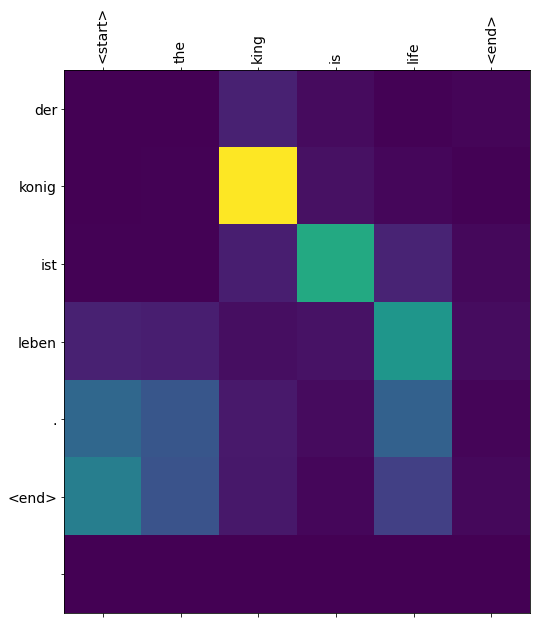

In [ ]:
translate(u"The king is life")

# Conclusion.

Well, the model doesn't perform as well as Google's NMT but it's a good start.